#### Top 10 USA States - Housing Prices - Excercise 1 - Dataset 2 - Timothy Gregorian

In this project, I used the same U.S. housing dataset as before (All_States_USA_ANN_Regression.ipynb) but focused only on the top 10 states with the most records. From these states, I randomly sampled data and trained a predictive model to estimate house prices. The goal was to test whether reducing the dataset to fewer but more consistent regions could improve the overall model performance and increase the R² score compared to using all states.

#### Use of AI
 I used AI to generate ideas on how to improve the error metrics (e.g., R², MSE, MAE, RMSE). The AI supported me in identifying possible causes for poor performance (such as dataset quality, feature encoding, scaling, or model architecture) and suggested alternative strategies.

#### Link to Dataset 2
https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

#### Information about the Dataset
This USA Housing Market Dataset contains around 2.2 million rows and 12 columns of real-estate related data, which can be used for housing price predictions.

#### Data Description
The dataset contains thousands of housing records from different U.S. states and includes multiple variables that can affect property prices. Some of the key variables are:

1) brokered_by: Real estate agency or broker responsible for the listing.

2) status: Current status of the property.

3) price: Selling price of the house -> target variable.

4) bed: Number of bedrooms.

5) bath: Number of bathrooms.

6) acre_lot: Lot size in acres.

7) street: Street address of the property.

8) city: City where the house is located.

9) state: State where the house is located.

10) zip_code: Postal code of the property.

11) house_size: Total living area of the house in square feet.

12) prev_sold_date: Date when the property was previously sold.

#### Import all necessary libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

import tensorflow as tf
import keras
from keras import layers 

#### Load the Dataset / Handle Missing Values
In the following code, "value_counts()" with "nlargest(10).index" counts the top 10 states of the USA with the most amount of data entries.

In [3]:
import pandas as pd

data = pd.read_csv("realtor-data.zip.csv")

drop_cols = ["brokered_by", "status", "street", "city", "prev_sold_date"]
data = data.drop(columns=drop_cols)

print("Shape after dropping irrelevant columns:", data.shape)

core_cols = ["price", "bed", "bath", "acre_lot", "house_size", "state", "zip_code"]
data = data.dropna(subset=core_cols)

print("Shape after removing NaN values in core variables:", data.shape)

data = data.drop_duplicates()
print("Shape after removing duplicates:", data.shape)

top10_states = data["state"].value_counts().nlargest(10).index
data = data[data["state"].isin(top10_states)]

print("Shape after filtering Top 10 states:", data.shape)

if len(data) >= 500_000:
    data = data.sample(n=500_000, random_state=7)
else:
    print(f"Warning -> Only {len(data)} rows available after filtering, using all rows instead!")

print("Shape after final sampling:", data.shape)


Shape after dropping irrelevant columns: (2226382, 7)
Shape after removing NaN values in core variables: (1360627, 7)
Shape after removing duplicates: (1259367, 7)
Shape after filtering Top 10 states: (719086, 7)
Shape after final sampling: (500000, 7)


In [4]:
print("Missing values after cleaning:\n", data.isna().sum())

Missing values after cleaning:
 price         0
bed           0
bath          0
acre_lot      0
state         0
zip_code      0
house_size    0
dtype: int64


In [5]:
print("Shape nach Duplikat-Entfernung:", data.shape)

Shape nach Duplikat-Entfernung: (500000, 7)


In [6]:
state_counts = data['state'].value_counts().sort_values(ascending=False)

print("Number of rows per state:\n", state_counts)

state_df = state_counts.reset_index()
state_df.columns = ['state', 'count']

print("\nShape of state_df:", state_df.shape)
print(state_df.head(10))  

Number of rows per state:
 state
California      107519
Texas            91985
Florida          81025
New York         34275
Pennsylvania     33895
Arizona          33500
Georgia          30829
Illinois         29622
Washington       28803
Virginia         28547
Name: count, dtype: int64

Shape of state_df: (10, 2)
          state   count
0    California  107519
1         Texas   91985
2       Florida   81025
3      New York   34275
4  Pennsylvania   33895
5       Arizona   33500
6       Georgia   30829
7      Illinois   29622
8    Washington   28803
9      Virginia   28547


In [7]:
def zipcode_to_region(zipcode):
    if 1 <= zipcode < 30000:
        return "East"
    elif 30000 <= zipcode < 50000:
        return "South"
    elif 50000 <= zipcode < 70000:
        return "North"
    else:
        return "West"

data["Region"] = data["zip_code"].apply(zipcode_to_region)

data = data.drop(columns=["Region_East", "Region_South", "Region_North", "Region_West"], errors="ignore")

data = pd.get_dummies(data, columns=["Region"], drop_first=False)

In [8]:
print("Columns after status encoding:", data.columns.tolist())

Columns after status encoding: ['price', 'bed', 'bath', 'acre_lot', 'state', 'zip_code', 'house_size', 'Region_East', 'Region_North', 'Region_South', 'Region_West']


In [9]:
y = data["price"]
X = data.drop(["price", "zip_code"], axis=1)  

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (500000, 9)
Shape of y: (500000,)


#### Correlation

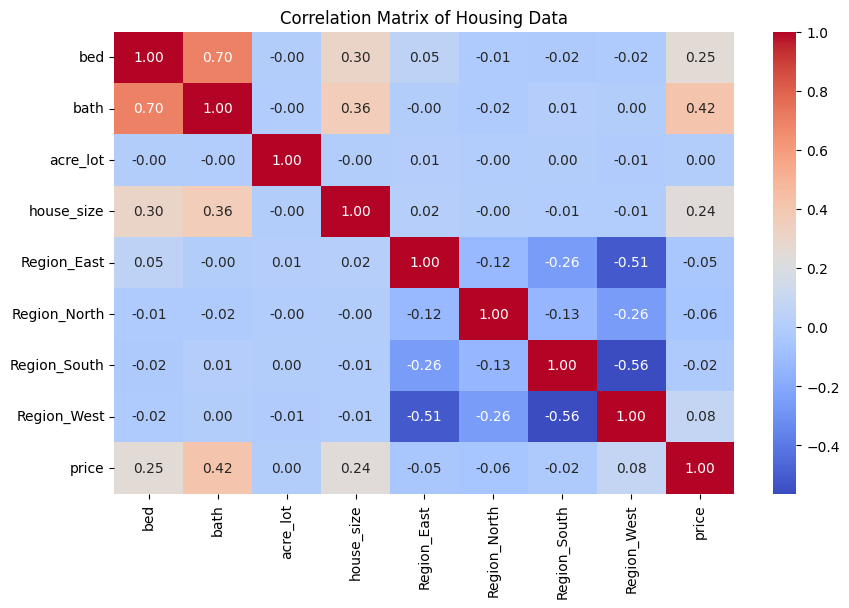

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X.join(y).corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Housing Data")
plt.show()

In the Top 10 states dataset, the correlations are generally similar to the full dataset: bedrooms and bathrooms remain strongly related, and both show a moderate positive link to price. However, the relationships of house_size and bathrooms with price appear slightly stronger, while regional effects remain weak, suggesting that limiting the dataset did not change the overall correlation patterns significantly.

#### Fisher-Score Test

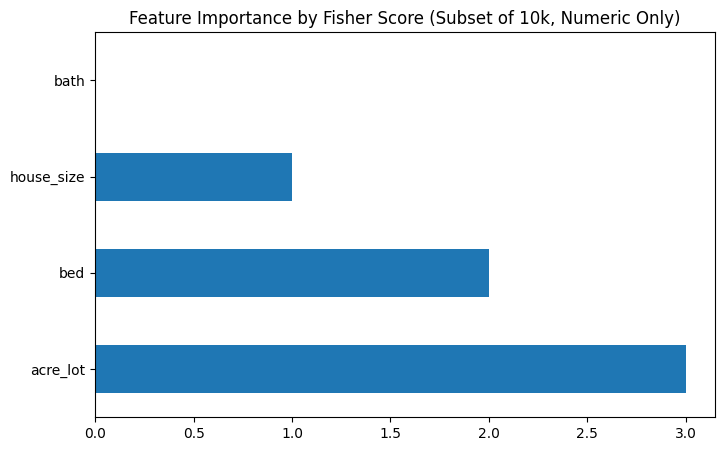

In [11]:
from skfeature.function.similarity_based import fisher_score

X_sub = X.sample(n=10000, random_state=7)
y_sub = y.loc[X_sub.index]

X_sub = X_sub.select_dtypes(include=["number"])

y_binned = pd.qcut(y_sub, q=4, labels=False)

ranks = fisher_score.fisher_score(X_sub.values, y_binned.values)
feat_importances = pd.Series(ranks, index=X_sub.columns)

feat_importances.sort_values(ascending=False).plot(kind="barh", figsize=(8, 5))
plt.title("Feature Importance by Fisher Score (Subset of 10k, Numeric Only)")
plt.show()


The results show that acre_lot and bedrooms are the most important features, while house_size has a smaller influence and bathrooms contribute the least. This is consistent with the full dataset.

#### Chi²-Test

In [12]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

X_num = X.select_dtypes(include=["number"])

X_cat = np.abs(X_num)

y_cat = pd.qcut(y, q=4, labels=False)

chi2_selector = SelectKBest(score_func=chi2, k="all")
chi2_selector.fit(X_cat, y_cat)

chi2_scores = pd.DataFrame({
    "Feature": X_num.columns,
    "Chi2 Score": chi2_selector.scores_
}).sort_values(by="Chi2 Score", ascending=False)

print(chi2_scores)


      Feature    Chi2 Score
3  house_size  7.292031e+07
2    acre_lot  1.788843e+06
1        bath  6.558322e+04
0         bed  2.147553e+04


House_size becomes the strongest predictor by far, followed by acre_lot, while bathrooms and especially bedrooms are less relevant. Compared to the larger dataset, the ranking is similar but with even clearer dominance of house_size.

#### VIF-Test

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_vif = X.select_dtypes(include=["number"]).copy()

X_vif = X_vif.astype(float)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

      Feature       VIF
0         bed  8.733776
1        bath  9.090048
2    acre_lot  1.000271
3  house_size  1.885591


The VIF values again show high multicollinearity between bedrooms and bathrooms, while acre_lot and house_size remain independent. The overall pattern is nearly the same as in the full dataset.

In [14]:
X = pd.get_dummies(X, columns=["state"], drop_first=False)

print("Shape after state encoding:", X.shape)

Shape after state encoding: (500000, 18)


In [15]:
print(X.columns.to_list())

['bed', 'bath', 'acre_lot', 'house_size', 'Region_East', 'Region_North', 'Region_South', 'Region_West', 'state_Arizona', 'state_California', 'state_Florida', 'state_Georgia', 'state_Illinois', 'state_New York', 'state_Pennsylvania', 'state_Texas', 'state_Virginia', 'state_Washington']


#### Train-/Test-/Validation-Split (70%/15%/15%)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=7
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=7
)

print("Training size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Training size: (350000, 18)
Validation size: (75000, 18)
Test size: (75000, 18)


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

#### Neural Network Architecture

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

variable_amount = len(X.columns)

neural_model_21 = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ]
)

neural_model_21.compile(
    optimizer="adam",
    loss="mse"
)

neural_model_21.summary()

d:\5. Semester\Deep Learning\DL-projects\venv312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 18)             │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,873 (50.29 KB)

 Trainable params: 12,837 (50.14 KB)

 Non-trainable params: 36 (144.00 B)

#### Training the model

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",  
    patience=18,         
    restore_best_weights=True
)

mc = ModelCheckpoint(
    'best_model_top10_states_dataset-regression.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    verbose=1
)

callback_list = [early_stop, mc, reduce_lr]

history = neural_model_21.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=1024,
    validation_data=(X_val, y_val),
    callbacks=callback_list,
    verbose=1
)

Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1996114493440.0000 - val_loss: 1921939931136.0000 - learning_rate: 0.0010
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1335545298944.0000 - val_loss: 1668061855744.0000 - learning_rate: 0.0010
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1197529890816.0000 - val_loss: 1637586042880.0000 - learning_rate: 0.0010
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1146719305728.0000 - val_loss: 1533500588032.0000 - learning_rate: 0.0010
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1108839890944.0000 - val_loss: 1501132357632.0000 - learning_rate: 0.0010
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1085539221504.0000 - val_loss: 1569078378496.0000 - learning_rate: 0.0010
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1062389088256.0000 - val_loss: 1422824046592.0000 - learning_rate: 0.0010
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - 

#### Visualisation / Results

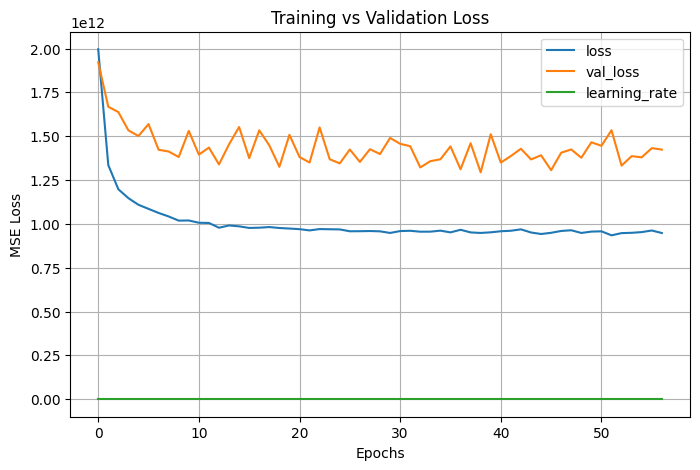

In [20]:
loss_df = pd.DataFrame(neural_model_21.history.history)
loss_df.plot(figsize=(8,5))
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

The graph shows that the training loss stays low and stable, while the validation loss fluctuates with occasional large spikes. This suggests that the model can learn the training data but still has instability when applied to unseen validation data.

#### Reload the best version of the model form history 

In [21]:
from keras.models import load_model
best_trained_model = load_model("best_model_top10_states_dataset-regression.keras")

In [22]:
print("Test data evaluation")
print(best_trained_model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(best_trained_model.evaluate(X_train, y_train, verbose=0))

Test data evaluation
1632077479936.0

Train data evaluation:
4027747926016.0


The evaluation shows very high error values for both training and test data, which means the model was not able to capture the underlying patterns well. This indicates poor predictive performance, even when focusing only on the Top 10 states.

In [23]:
import seaborn as sns

test_predictions = best_trained_model.predict(X_test)
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))

pred_df = pd.DataFrame(pd.DataFrame(np.asarray(y_test), columns=["Test True Y"]))
pred_df = pd.concat([pred_df, test_predictions], axis = 1)
pred_df.columns = ["Test True Y", "Model Predictions"]

pred_df

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 725us/step


,Test True Y,Model Predictions
0,532500.0,4.404036e+05
1,99900.0,2.894309e+05
2,985000.0,9.825772e+05
3,584900.0,8.227871e+05
4,915000.0,3.607540e+05
...,...,...
74995,324850.0,4.563631e+05
74996,460000.0,1.188413e+06
74997,225000.0,6.170730e+05
74998,300000.0,7.367315e+05


#### Scatterplot

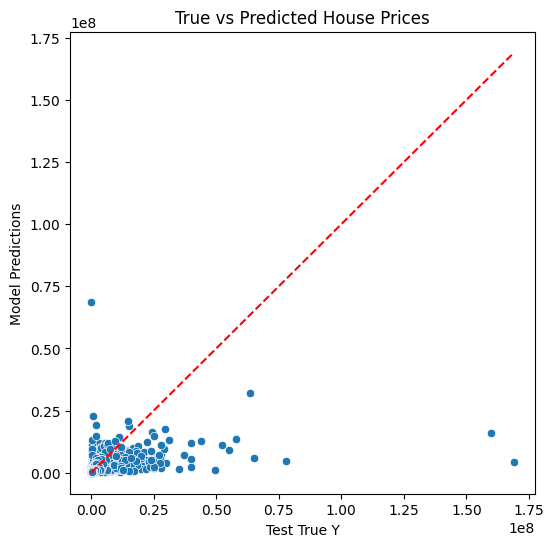

In [24]:
plt.figure(figsize=(6,6))
sns.scatterplot(x="Test True Y", y="Model Predictions", data=pred_df)

min_val = min(pred_df["Test True Y"].min(), pred_df["Model Predictions"].min())
max_val = max(pred_df["Test True Y"].max(), pred_df["Model Predictions"].max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")

plt.title("True vs Predicted House Prices")
plt.xlabel("Test True Y")
plt.ylabel("Model Predictions")
plt.show()

The scatterplot shows that most predictions are clustered far below the red diagonal line, which represents perfect accuracy. This means the model consistently underestimates house prices and struggles to match the true values.

#### Error-Metrics

In [25]:
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
291117.28 $

MSE
1632077306724.69 $^2

RMSE:
1277527.81 $

R-squared:
0.28

Explained variance score:
0.28


The evaluation metrics show very high prediction errors (MAE and RMSE), but the R² score of 0.28 is higher than in the full dataset. This means the model explains slightly more variance in house prices when trained only on the Top 10 states, though accuracy remains limited.

C:\Users\Timothy\AppData\Local\Temp\ipykernel_20108\3264322254.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


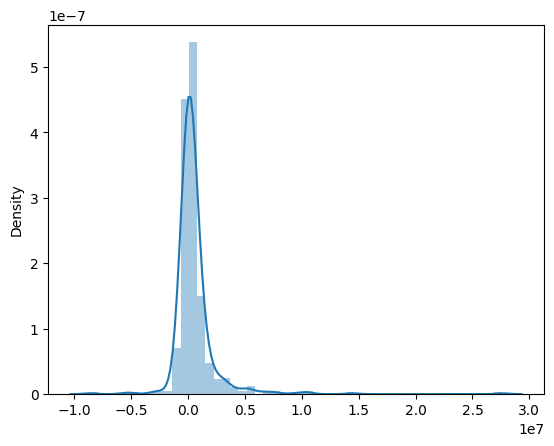

In [26]:
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

The distplot shows that most residuals are concentrated close to zero, but there are still noticeable outliers. This suggests the model captures general trends better than before, yet still makes large errors for some houses.

In [27]:
X.columns

Index(['bed', 'bath', 'acre_lot', 'house_size', 'Region_East', 'Region_North',
       'Region_South', 'Region_West', 'state_Arizona', 'state_California',
       'state_Florida', 'state_Georgia', 'state_Illinois', 'state_New York',
       'state_Pennsylvania', 'state_Texas', 'state_Virginia',
       'state_Washington'],
      dtype='object')

In [28]:
X.head(3)

,bed,bath,acre_lot,house_size,Region_East,Region_North,Region_South,Region_West,state_Arizona,state_California,state_Florida,state_Georgia,state_Illinois,state_New York,state_Pennsylvania,state_Texas,state_Virginia,state_Washington
2138264,1.0,1.0,1.16,666.0,False,False,False,True,False,True,False,False,False,False,False,False,False,False
1514744,3.0,2.0,0.42,1722.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False
1098561,4.0,4.0,0.15,2435.0,False,False,False,True,False,False,False,False,False,False,False,True,False,False


#### Prediction-Example

In [29]:
tester_row = {
    "bed": 5,
    "bath": 2,
    "acre_lot": 0.16,
    "house_size": 2358,
    "Region_East": 1,
    "Region_North": 0,
    "Region_South": 0,
    "Region_West": 0,

    'state_Arizona': 0,
    'state_California': 1,
    'state_Florida': 0,
    'state_Georgia': 0,
    'state_Illinois': 0,
    'state_New York': 0,
    'state_Pennsylvania': 0,
    'state_Texas': 0,
    'state_Virginia': 0,
    'state_Washington': 0
}
#2067775

tester_row = pd.DataFrame([tester_row])

tester_row_scaled = scaler.transform(tester_row)

result = best_trained_model.predict(tester_row_scaled)[0][0]

print("Estimated house price with this example: ")
print(f"${round(float(result), 2)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Estimated house price with this example: 
$472426.25


In [30]:
tester_row2 = {
    "bed": 5,
    "bath": 2,
    "acre_lot": 0.16,
    "house_size": 2358,
    "Region_East": 0,
    "Region_North": 1,
    "Region_South": 0,
    "Region_West": 0,

    'state_Arizona': 0,
    'state_California': 1,
    'state_Florida': 0,
    'state_Georgia': 0,
    'state_Illinois': 0,
    'state_New York': 0,
    'state_Pennsylvania': 0,
    'state_Texas': 0,
    'state_Virginia': 0,
    'state_Washington': 0
}
#2067775

tester_row2 = pd.DataFrame([tester_row2])

tester_row_scaled2 = scaler.transform(tester_row2)

result = best_trained_model.predict(tester_row_scaled2)[0][0]

print("Estimated house price with this example: ")
print(f"${round(float(result), 2)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Estimated house price with this example: 
$184517.89


In [31]:
tester_row3 = {
    "bed": 5,
    "bath": 2,
    "acre_lot": 0.16,
    "house_size": 2358,
    "Region_East": 0,
    "Region_North": 0,
    "Region_South": 1,
    "Region_West": 0,

    'state_Arizona': 0,
    'state_California': 1,
    'state_Florida': 0,
    'state_Georgia': 0,
    'state_Illinois': 0,
    'state_New York': 0,
    'state_Pennsylvania': 0,
    'state_Texas': 0,
    'state_Virginia': 0,
    'state_Washington': 0
}
#2067775

tester_row3 = pd.DataFrame([tester_row3])

tester_row_scaled3 = scaler.transform(tester_row3)

result = best_trained_model.predict(tester_row_scaled3)[0][0]

print("Estimated house price with this example: ")
print(f"${round(float(result), 2)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Estimated house price with this example: 
$420581.88


In [32]:
tester_row4 = {
    "bed": 5,
    "bath": 2,
    "acre_lot": 0.16,
    "house_size": 2358,
    "Region_East": 0,
    "Region_North": 0,
    "Region_South": 0,
    "Region_West": 1,

    'state_Arizona': 0,
    'state_California': 1,
    'state_Florida': 0,
    'state_Georgia': 0,
    'state_Illinois': 0,
    'state_New York': 0,
    'state_Pennsylvania': 0,
    'state_Texas': 0,
    'state_Virginia': 0,
    'state_Washington': 0
}
#2067775

tester_row4 = pd.DataFrame([tester_row4])

tester_row_scaled4 = scaler.transform(tester_row4)

result = best_trained_model.predict(tester_row_scaled4)[0][0]

print("Estimated house price with this example: ")
print(f"${round(float(result), 2)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Estimated house price with this example: 
$766600.06


#### Model Evaluation and Prediction Analysis
For the property in row "2067775" of the CSV-dataset (California), the actual sale price was $1,318,850.00. When predicting the same house with fixed features but switching the regional indicator, the model gave the following estimates:

East -> $472,426.25

North -> $184,517.89

South -> $420,581.88

West -> $766,600.06

All four predictions fall well below the true market price, with the West region coming closest at about $766,600.06, while the North region is the lowest at only $184,517.89.

This pattern indicates that the model underestimates high-value California properties and that the encoded regional feature has a very strong influence on the predictions. However, the spread between regions also shows that the network has difficulty generalizing consistent price levels for the same house when only the region changes.

#### Conclusion

At the beginning, I faced similar challenges as in the previous project, especially with scaling and handling categorical variables like states. By applying one-hot encoding and focusing only on the Top 10 states, the dataset became more consistent and easier for the model to learn from. Another difficulty was again designing the right model architecture, since early attempts produced unstable results. After multiple tests and optimizations, the model achieved a higher R² score of 0.28, which shows an improvement compared to using all states.

I believe that the main reason for this improvement is the reduction in dataset complexity. When too many states are included, the variation and noise make it difficult for the model to capture meaningful patterns. By limiting the scope to fewer states, the model was able to generalize better and improve its prediction quality, even though the error values like MAE and RMSE remained very high. In working life, predictive models like this can still be very useful for price estimation, market analysis, and risk assessment, but their accuracy strongly depends on the quality and structure of the available data. For further optimization, I would consider adding more relevant features, trying alternative model architectures, and applying stronger regularization or ensemble methods to improve stability and reduce variance.